In [5]:
%load_ext autoreload
%autoreload 2

#%pip install keras-tuner


from pathlib import Path
import os
import sys
sys.path.insert(0, "..")
sys.path

import numpy as np
import seaborn as sns
sns.set_theme()

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers



from src.data import make_dataset


from src.visualization import visualize_simple





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
datadir_processed = Path("../data/processed")
datadir_model = Path("../models")

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [28]:
data = []
labels = []

for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        #print(f"{f} is a target class")
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, 
            target_size= (64,64))
            image=np.array(image)
            data.append(image)
            labels.append(f)

data = np.array(data)
#labels = np.array(labels)
labels = list(labels)
#labels_text = labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
#labels = to_categorical(labels)



X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125,
                                                random_state=42)




# Pre-processing
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)


(12414, 64, 64, 3)
(3548, 64, 64, 3)
(1774, 64, 64, 3)


In [ ]:
simple_model2 = keras.models.Sequential([


keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(128,128,3)),
keras.layers.LeakyReLU(alpha=0.2),
#keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2)),
#keras.layers.Dropout(rate=0.2),

keras.layers.Conv2D(64, (3,3)),
keras.layers.LeakyReLU(alpha=0.2),
#keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2)),
#keras.layers.Dropout(rate=0.2),

keras.layers.Conv2D(64, (1,1)),
keras.layers.LeakyReLU(alpha=0.2),
#keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2)),
#keras.layers.Dropout(rate=0.2),

keras.layers.Flatten(),
keras.layers.Dropout(rate=0.2),
#keras.layers.BatchNormalization(),

keras.layers.Dense(150),
keras.layers.LeakyReLU(alpha=0.2),
keras.layers.Dropout(rate=0.2),
#keras.layers.BatchNormalization(),

keras.layers.Dense(84),
keras.layers.LeakyReLU(alpha=0.2),
keras.layers.Dropout(rate=0.2),
#keras.layers.BatchNormalization(),
keras.layers.Dense(10, activation="softmax")
])

simple_model2.summary()



In [10]:
from kerastuner import HyperModel

INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = 10

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            keras.layers.Conv2D(
                filters=hp.Choice(
                    'num_filters_1',
                    values=[32, 64, 128],
                    default=64,
                ),
                kernel_size=(3,3),
                
                input_shape=self.input_shape
            )
        )

        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.MaxPooling2D(pool_size=2))
               
        
        model.add(
            keras.layers.Conv2D(
                filters=hp.Choice(
                    'num_filters_2',
                    values=[32, 64, 128],
                    default=64,
                ),
                activation='relu',
                kernel_size=(3,3)
            )
        )

       

        model.add(
            keras.layers.Conv2D(
                filters=hp.Choice(
                    'num_filters_3',
                    values=[32, 64, 128],
                    default=64,
                ),
                activation='relu',
                kernel_size=(1,1)
            )
        )

        model.add(keras.layers.MaxPooling2D(pool_size=2))
        model.add(
            keras.layers.Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )


        model.add(keras.layers.Flatten())
        model.add(
            keras.layers.Dense(
                units=hp.Int(
                    'units_1',
                    min_value=32,
                    max_value=256,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        
        model.add(
            keras.layers.Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )

        model.add(
            keras.layers.Dense(
                units=hp.Int(
                    'units_2',
                    min_value=32,
                    max_value=128,
                    step=16,
                    default=64
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )

        model.add(
            keras.layers.Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

C:\Users\hjtfs\AppData\Local\Temp/ipykernel_17592/2593664678.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [11]:
import keras_tuner as kt
from kerastuner.tuners import Hyperband

tuner = kt.Hyperband(
    hypermodel,
    overwrite=True,
    objective='val_accuracy',
    max_epochs=20,
    executions_per_trial=1,
    hyperband_iterations=1,
    directory=''
    project_name='galaxies')

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
num_filters_1 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
num_filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_1 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_v

In [13]:
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             batch_size=32,
             #epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])

Trial 30 Complete [00h 01m 21s]
val_accuracy: 0.14712513983249664

Best val_accuracy So Far: 0.6516347527503967
Total elapsed time: 01h 46m 45s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in .\galaxies
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_filters_1: 128
num_filters_2: 128
num_filters_3: 32
dropout_1: 0.2
units_1: 128
dense_activation: relu
dropout_2: 0.4
units_2: 64
dropout_3: 0.25
learning_rate: 0.001266095545138909
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 583d3b1ddd9ce5d77753e20016b81da3
Score: 0.6516347527503967
Trial summary
Hyperparameters:
num_filters_1: 32
num_filters_2: 64
num_filters_3: 128
dropout_1: 0.30000000000000004
units_1: 64
dense_activation: tanh
dropout_2: 0.2
units_2: 112
dropout_3: 0.45
learning_rate: 0.0003367031646782763
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: b8ab66cb5738b62773cb114c9101cfe8
Score: 0.6505073308944702
Trial summary
Hyperparameters:
num_filters_1: 32
num_filters_2: 32
num_filters_3: 128
dropout_1: 0.5
units_1: 192
dense_activation: relu
dropout_2:

In [15]:
best_hp=tuner.get_best_hyperparameters()[0]

In [16]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [18]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

111/111 [==============================] - 5s 40ms/step - loss: 1.0675 - accuracy: 0.6471


In [ ]:
def build_model(hp):
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 3, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  return model


In [ ]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)

In [24]:

model_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

best_model.compile(optimizer=model_optimizer, loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

reduceLR = ReduceLROnPlateau(monitor='val_accuracy', 
factor=.001, 
patience=1, 
min_delta=0.01, 
mode="auto")




In [25]:
hist_simple_model2 = best_model.fit(X_train, y_train, epochs=10,
validation_data=(X_valid, y_valid),
callbacks=[reduceLR])

Epoch 1/10
388/388 [==============================] - 61s 156ms/step - loss: 0.8815 - accuracy: 0.6995 - val_loss: 1.0984 - val_accuracy: 0.6251 - lr: 0.0020
Epoch 2/10
388/388 [==============================] - 61s 158ms/step - loss: 0.8586 - accuracy: 0.7031 - val_loss: 1.0421 - val_accuracy: 0.6392 - lr: 0.0020
Epoch 3/10
388/388 [==============================] - 62s 160ms/step - loss: 0.8263 - accuracy: 0.7122 - val_loss: 1.1183 - val_accuracy: 0.6234 - lr: 0.0020
Epoch 4/10
388/388 [==============================] - 60s 154ms/step - loss: 0.7878 - accuracy: 0.7268 - val_loss: 1.1000 - val_accuracy: 0.6313 - lr: 2.0000e-06
Epoch 5/10
388/388 [==============================] - 61s 157ms/step - loss: 0.7650 - accuracy: 0.7347 - val_loss: 1.1000 - val_accuracy: 0.6313 - lr: 2.0000e-09
Epoch 6/10
388/388 [==============================] - 60s 155ms/step - loss: 0.7802 - accuracy: 0.7258 - val_loss: 1.1000 - val_accuracy: 0.6313 - lr: 2.0000e-12
Epoch 7/10
388/388 [====================

In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=20,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

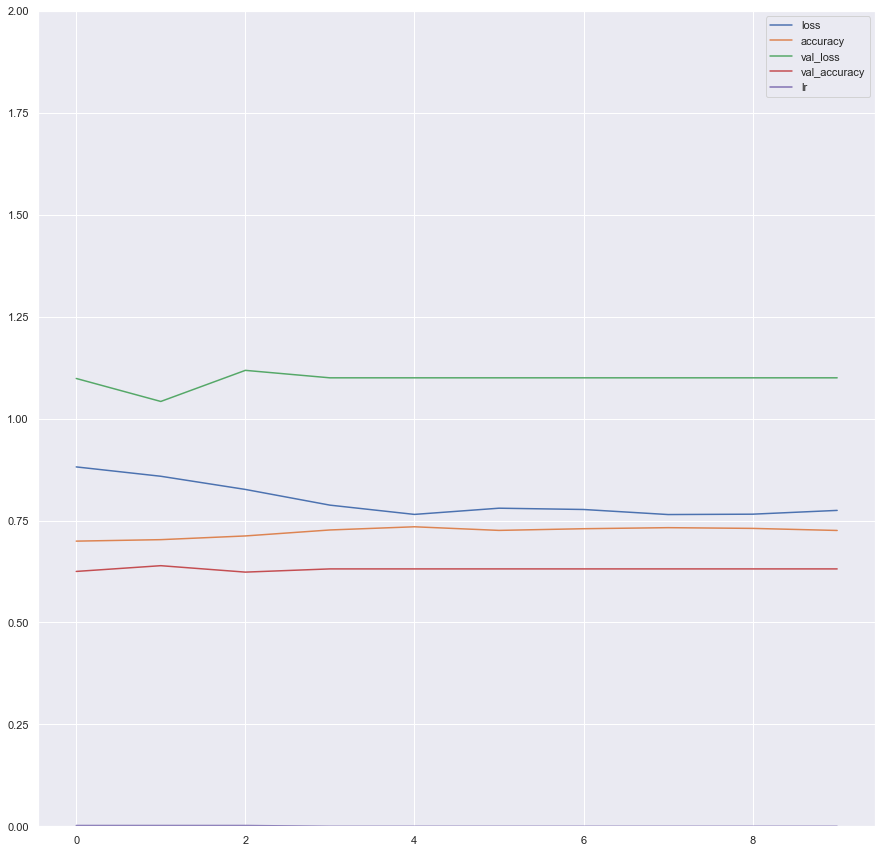

In [26]:
pd.DataFrame(hist_simple_model2.history).plot(figsize=(15, 15))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-2]
plt.show()

In [29]:
#y_test = np.argmax(y_test,axis=1)
predict = best_model.predict(X_test).argmax(axis=1)


In [30]:
#encoder = LabelEncoder()
#y_test = encoder.fit_transform(y_test)
#predict = encoder.fit_transform(predict)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       393
           1       0.54      0.28      0.37        68
           2       0.17      0.00      0.01       218
           3       0.69      0.84      0.76       378
           4       0.83      0.70      0.76       279
           5       0.63      0.64      0.64       380
           6       0.81      0.86      0.83       563
           7       0.64      0.80      0.71       399
           8       0.47      0.43      0.45       516
           9       0.51      0.65      0.57       354

    accuracy                           0.64      3548
   macro avg       0.59      0.58      0.57      3548
weighted avg       0.61      0.64      0.62      3548



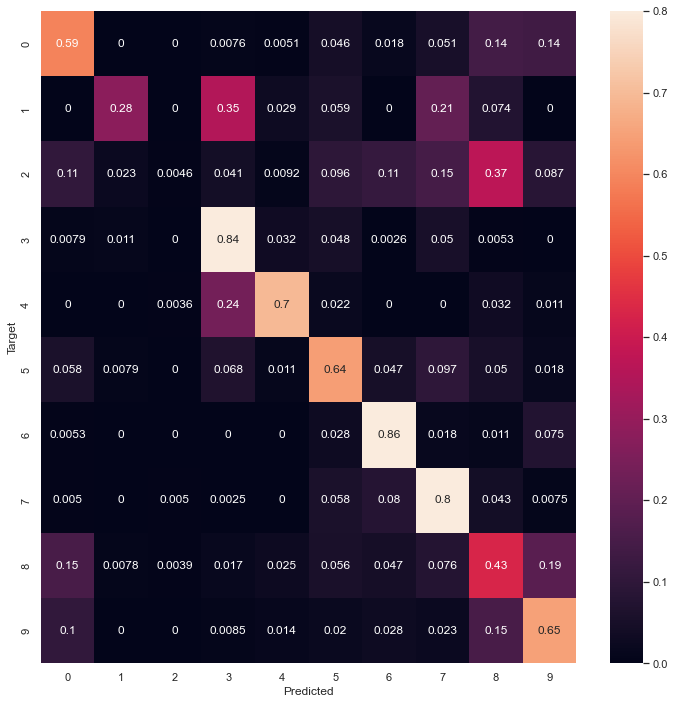

In [32]:
cfm = confusion_matrix(y_test, predict)
visualize_simple.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.8)